# Importação de bibliotecas e acesso a arquivos via Google Drive

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

DRIVE_FOLDER = '/content/drive/My Drive/DatasetColab/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pré-processamento de dados (igual ao código anterior)

* Carrega um dataset de notícias de futebol usando Pandas.
* Realiza limpeza e combinação de colunas de texto.
* Aplica um LabelEncoder para transformar nomes de clubes em identificadores numéricos.
* Utiliza o spaCy para processamento de linguagem natural, como remover pontuação, números, acentos e aplicar lematização.
* Instala e carrega um modelo de linguagem específico para o português.

In [ ]:
import pandas as pd

caminho_do_arquivo = DRIVE_FOLDER + 'ge_news.csv'
df = pd.read_csv(caminho_do_arquivo)

df.head()

,date,time,title,text,link,club
0,10/11/2022,19h55,Convocados do Uruguai para a Copa do Mundo 202...,O técnico Diego Alonso divulgou a lista dos 2...,https://ge.globo.com/futebol/copa-do-mundo/not...,athletico-pr
1,22/12/2017,10h04,Conmebol divulga tabela detalhada da pré e da ...,Argentinos são destaques no caminho dos brasi...,https://globoesporte.globo.com/futebol/liberta...,athletico-pr
2,11/02/2018,08h00,"Com assistência, Demethryus recebe elogios no ...",O meia Demethryus conseguiu aproveitar bem a ...,https://globoesporte.globo.com/pr/futebol/time...,athletico-pr
3,18/12/2020,12h48,Athletico confirma fim de contrato com Welling...,A reportagem do ge já havia adiantado que as ...,https://globoesporte.globo.com/pr/futebol/time...,athletico-pr
4,13/09/2018,22h17,"Alô, cartoleiros! Atlético-PR passa limpo cont...","O atacante Marcelo Cirino, desfalque já nos ú...",https://globoesporte.globo.com/pr/futebol/time...,athletico-pr


In [ ]:
# Removendo simultaneamente as colunas de índice 0, 1, 4 (date, time and link)
column_indices = [0, 1, 4]
df.drop([df.columns[i] for i in column_indices], axis=1, inplace=True)

# Fundindo colunas 'title' e 'text' para a coluna 'title_and_text'
df['data'] = df['title'] + ' ' + df['text']

df.head()

,title,text,club,data
0,Convocados do Uruguai para a Copa do Mundo 202...,O técnico Diego Alonso divulgou a lista dos 2...,athletico-pr,Convocados do Uruguai para a Copa do Mundo 202...
1,Conmebol divulga tabela detalhada da pré e da ...,Argentinos são destaques no caminho dos brasi...,athletico-pr,Conmebol divulga tabela detalhada da pré e da ...
2,"Com assistência, Demethryus recebe elogios no ...",O meia Demethryus conseguiu aproveitar bem a ...,athletico-pr,"Com assistência, Demethryus recebe elogios no ..."
3,Athletico confirma fim de contrato com Welling...,A reportagem do ge já havia adiantado que as ...,athletico-pr,Athletico confirma fim de contrato com Welling...
4,"Alô, cartoleiros! Atlético-PR passa limpo cont...","O atacante Marcelo Cirino, desfalque já nos ú...",athletico-pr,"Alô, cartoleiros! Atlético-PR passa limpo cont..."


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Cria um objeto LabelEncoder
le = LabelEncoder()

# Treinando o codificador de rótulos, transformando o nome do clube em um identificador numérico
df['label'] = le.fit_transform(df['club'])

# Removendo as colunas originais, não precisamos mais delas
column_indices = [0, 1, 2]
df.drop([df.columns[i] for i in column_indices], axis=1, inplace=True)

df.head()

,data,label
0,Convocados do Uruguai para a Copa do Mundo 202...,0
1,Conmebol divulga tabela detalhada da pré e da ...,0
2,"Com assistência, Demethryus recebe elogios no ...",0
3,Athletico confirma fim de contrato com Welling...,0
4,"Alô, cartoleiros! Atlético-PR passa limpo cont...",0


In [ ]:
# Instalando uma versão atualizada de um grande modelo de linguagem pré-treinado em português
!pip install https://github.com/explosion/spacy-models/releases/download/pt_core_news_lg-3.7.0/pt_core_news_lg-3.7.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 6.1 MB/s eta 0:00:00
  Created wheel for pt-core-news-lg: filename=pt_core_news_lg-3.7.0-py3-none-any.whl size=568212788 sha256=90b3b855e7c0b7c3088826993a104e5cc4e2654b9fb3a7f3630efc0c64501b9e
  Stored in directory: /root/.cache/pip/wheels/77/74/94/d4876f7b34383fdabdb61a2433a302ac487a87e8a6ce7925dc
Successfully built pt-core-news-lg
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
e

In [ ]:
import string
import spacy
import unicodedata
from tqdm import tqdm
import pandas as pd
import numpy as np

# Habilita o suporte do tqdm para métodos de progressão do pandas (como progress_apply)
# Com isso, é possível ver barras de progresso em operções feitas no Pandas
tqdm.pandas()

# Carrega o modelo de linguagem 'pt_core_news_lg' do spaCy para processamento de texto em português
# Desabilita os componentes 'parser' e 'ner', já que não são necessários para a lematização
spacy_nlp_model = spacy.load("pt_core_news_lg", disable=["parser", "ner"])

def preprocess_data(df, text_column):
    """
    Realiza o pré-processamento dos dados de texto em um DataFrame do Pandas.
    Remove pontuação, números e palavras comuns (stop words), converte para mínusculas,
    remove acentos e símbolos diversos, e aplica lematização.
    """

    # Cria uma tabela de tradução que mapeia cada caractere de pontuação do módulo `string.punctuation`
    # para `None` (ou seja, remove-os do texto).
    print("Removendo pontuação...")
    translator = str.maketrans('', '', string.punctuation) # Só usamos o terceiro parâmetro, que mapeia ocorrências de string.punctuation para None
    df[text_column] = df[text_column].progress_apply(lambda x: x.translate(translator))

    print("Removendo números...")
    translator = str.maketrans('', '', string.digits)
    df[text_column] = df[text_column].progress_apply(lambda x: x.translate(translator))

    print("Removendo acentos e símbolos diversos...")
    def remove_accents_and_symbols(text):
        try:
            # Normaliza a string para a forma NFKD e mantém apenas caracteres que não são diacríticos
            # nem combinam caracteres com diacríticos
            return ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c) and unicodedata.category(c) != 'Mn')
        except TypeError:
            # Se não for possível normalizar um caractere, retorna uma string vazia
            return ''

    # Aplica a função 'remove_accents_and_symbols' na coluna 'text_column'
    df[text_column] = df[text_column].progress_apply(lambda x: remove_accents_and_symbols(x))

    print("Convertendo para minúsculas...")
    df[text_column] = df[text_column].progress_apply(lambda x: x.lower())

    print("Computando Lematização...")
    def lemmatize_text(doc):
        return [token.lemma_ for token in doc if not token.is_stop]

    n_chunks = 10  # Ajuste esse valor de acordo com o tamanho da base de dados e a memória disponível no sistema
    chunks = np.array_split(df, n_chunks) # Divide o dataframe em várias partes

    processed_chunks = []
    for i, chunk in enumerate(chunks):
        print(f"Processando segmento {i + 1} de {n_chunks}")
        processed_chunk = chunk.copy() # Cria uma cópia para realizar o processamento

        #  Aplica a função 'lemmatize_text' a cada documento processado pelo spaCy (usando 'spacy_nlp_model.pipe') e
        # atribui os resultados (uma lista de palavras lematizadas) à coluna 'text_column' do DataFrame 'processed_chunk'.
        # O tqdm é utilizado para exibir uma barra de progresso durante o processamento dos documentos.
        processed_chunk[text_column] = [lemmatize_text(doc) for doc in tqdm(spacy_nlp_model.pipe(chunk[text_column].astype(str), batch_size=100, disable=['parser', 'ner']), total=len(chunk[text_column]))]

        # Junta as partes em uma lista, para formar o dataframe final
        processed_chunks.append(processed_chunk)

    concatenated_df = pd.concat(processed_chunks) # Concatenar os DataFrames processados
    df[text_column] = concatenated_df[text_column] # Atribuir a coluna 'data' processada de volta ao dataframe original

    print("Remover tokens com espaços vazios...")
    df['data'] = df['data'].progress_apply(lambda x: [token for token in x if token.strip()])

In [ ]:
preprocess_data(df, 'data') # Realiza o pré-processamento

Removendo pontuação...


100%|██████████| 191005/191005 [01:07<00:00, 2811.27it/s]


Removendo números...


100%|██████████| 191005/191005 [00:56<00:00, 3384.19it/s]


Removendo acentos e símbolos diversos...


100%|██████████| 191005/191005 [03:06<00:00, 1021.72it/s]


Convertendo para minúsculas...


100%|██████████| 191005/191005 [00:01<00:00, 118707.85it/s]


Computando Lematização...
Processando segmento 1 de 10


100%|██████████| 19101/19101 [09:04<00:00, 35.10it/s]


Processando segmento 2 de 10


100%|██████████| 19101/19101 [09:47<00:00, 32.53it/s]


Processando segmento 3 de 10


100%|██████████| 19101/19101 [09:16<00:00, 34.29it/s]


Processando segmento 4 de 10


100%|██████████| 19101/19101 [09:06<00:00, 34.96it/s]


Processando segmento 5 de 10


100%|██████████| 19101/19101 [10:27<00:00, 30.42it/s]


Processando segmento 6 de 10


100%|██████████| 19100/19100 [08:35<00:00, 37.02it/s]


Processando segmento 7 de 10


100%|██████████| 19100/19100 [09:31<00:00, 33.43it/s]


Processando segmento 8 de 10


100%|██████████| 19100/19100 [08:59<00:00, 35.37it/s]


Processando segmento 9 de 10


100%|██████████| 19100/19100 [09:17<00:00, 34.26it/s]


Processando segmento 10 de 10


100%|██████████| 19100/19100 [09:40<00:00, 32.90it/s]


Remover tokens com espaços vazios...


100%|██████████| 191005/191005 [00:12<00:00, 15097.91it/s]


In [ ]:
# Salva em disco um dataframe com as notícias de futebol já pré-processadas
df.to_pickle(DRIVE_FOLDER + 'ge_df.pkl')

# Preparação dos dados para o modelo de machine learning

* Realiza tokenização dos textos, convertendo-os em sequências numéricas que representam palavras.
* Calcula o comprimento máximo das sequências e aplica padding para normalizar o comprimento.
* Carrega embeddings pré-treinados do GloVe para representação vetorial das palavras.
* Prepara os rótulos (labels) para treinamento usando one-hot encoding.

In [ ]:
import pandas as pd

# Carregamento do dataframe com notícias pré-processadas
df = pd.read_pickle(DRIVE_FOLDER + 'ge_df.pkl')

In [ ]:
df.head()

,data,label
0,"[convocar, uruguai, copa, mundo, lista, tecnic...",0
1,"[conmebol, divulgar, tabela, detalhar, pre, fa...",0
2,"[assistencia, demethryus, receber, elogio, atl...",0
3,"[athletico, confirmar, contrato, wellington, n...",0
4,"[alo, cartoleiro, atleticopr, passar, limpo, c...",0


In [ ]:
texts = df['data'].tolist()  # Converte as notícias em listas de palavras, algo que o Tokenizador espera
labels = df['label'].tolist()  # Rótulos das notícias

In [ ]:
# Tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

In [ ]:
#word_index é um dicionário onde as chaves são as palavras e os valores são os índices dessas palavras.
#Esse índice é útil para várias tarefas de NLP, como a criação de embeddings de palavras ou a preparação de dados para modelos de deep learning.
word_index

{'nao': 1,
 'jogo': 2,
 'gol': 3,
 'clube': 4,
 'sao': 5,
 'time': 6,
 'jogador': 7,
 'ano': 8,
 'equipe': 9,
 'partida': 10,
 'paulo': 11,
 '–': 12,
 'tambem': 13,
 'ja': 14,
 '—': 15,
 'ge': 16,
 'ate': 17,
 'ser': 18,
 'rodada': 19,
 'flamengo': 20,
 'vitoria': 21,
 'brasileiro': 22,
 'dia': 23,
 'ultimo': 24,
 'palmeira': 25,
 'campeonato': 26,
 'tecnico': 27,
 'noticia': 28,
 'bom': 29,
 'jogar': 30,
 'ficar': 31,
 'fotor': 32,
 'campo': 33,
 'futebol': 34,
 'copa': 35,
 'chegar': 36,
 'h': 37,
 'brasileirao': 38,
 'apos': 39,
 'marcar': 40,
 'brasil': 41,
 'santo': 42,
 'voce': 43,
 'serie': 44,
 'x': 45,
 'ter': 46,
 'gremio': 47,
 'fluminense': 48,
 'temporada': 49,
 'atacante': 50,
 'cruzeiro': 51,
 'gente': 52,
 'voltar': 53,
 'acabar': 54,
 'botafogo': 55,
 'bola': 56,
 'vasco': 57,
 'atleta': 58,
 'r': 59,
 'passar': 60,
 'so': 61,
 'proximo': 62,
 'vencer': 63,
 'sera': 64,
 'inter': 65,
 'libertador': 66,
 'casa': 67,
 'tres': 68,
 'entrar': 69,
 'fazer': 70,
 'ir': 71,
 

In [ ]:
import pickle

# Salva o tokenizador em um arquivo (precisamos dele mais tarde, quando realizarmos as inferências)
with open(DRIVE_FOLDER + 'tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [ ]:
import numpy as np

# Calcula o comprimento de cada sequência em 'sequences' e armazena os resultados na lista 'sequence_lengths'
sequence_lengths = [len(seq) for seq in sequences]

# Calcula a média dos comprimentos das sequências usando a função 'mean' do numpy
mean_length = np.mean(sequence_lengths)

# Obtém o comprimento máximo das sequências usando a função 'max' do Python
max_length = max(sequence_lengths)

# Imprime a média e o comprimento máximo das sequências
print("Mean sequence length: ", mean_length)
print("Maximum sequence length: ", max_length)

Mean sequence length:  207.9075155100652
Maximum sequence length:  4967


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Calcula o percentil 95 dos comprimentos das sequências (preserva 95% das sequências)
max_length = int(np.percentile(sequence_lengths, 95))

# Realiza o preenchimento das sequências com base no novo 'max_length'
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# GLoVe

In [ ]:
# Carrega os embeddings do GLoVe
embeddings_index = {}
with open(DRIVE_FOLDER + 'glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
# Preparar a matriz de embedding
embedding_dim = 100  # o tamanho do seu GLoVe embeddings
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# One-hot encoding dos rótulos
num_classes = len(np.unique(labels))  # Número de classes únicas
labels = to_categorical(labels, num_classes=num_classes)

In [ ]:
from sklearn.model_selection import train_test_split

# Divida os dados em um conjunto de treino (70%) e um conjunto temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3)

# Divida o conjunto temporário em conjuntos de validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)  # 0.5 * 0.3 = 0.15

In [ ]:
# Construindo o modelo
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(num_classes, activation='softmax'))  # Camada de saída para classificação multiclasse

# Chamada ao Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(X_train, y_train, batch_size=128, epochs=40, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/40
1045/1045 [==============================] - 79s 69ms/step - loss: 1.3698 - accuracy: 0.6451 - val_loss: 0.9434 - val_accuracy: 0.7537
Epoch 2/40
1045/1045 [==============================] - 71s 68ms/step - loss: 0.8471 - accuracy: 0.7708 - val_loss: 0.7731 - val_accuracy: 0.7834
Epoch 3/40
1045/1045 [==============================] - 70s 67ms/step - loss: 0.7275 - accuracy: 0.7906 - val_loss: 0.6973 - val_accuracy: 0.7957
Epoch 4/40
1045/1045 [==============================] - 71s 68ms/step - loss: 0.6687 - accuracy: 0.7995 - val_loss: 0.6632 - val_accuracy: 0.7992
Epoch 5/40
1045/1045 [==============================] - 71s 68ms/step - loss: 0.6321 - accuracy: 0.8053 - val_loss: 0.6308 - val_accuracy: 0.8018
Epoch 6/40
1045/1045 [==============================] - 71s 68ms/step - loss: 0.6064 - accuracy: 0.8084 - val_loss: 0.6184 - val_accuracy: 0.8046
Epoch 7/40
1045/1045 [==============================] - 71s 68ms/step - loss: 0.5875 - accuracy: 0.8112 - val_loss: 0.6150 -

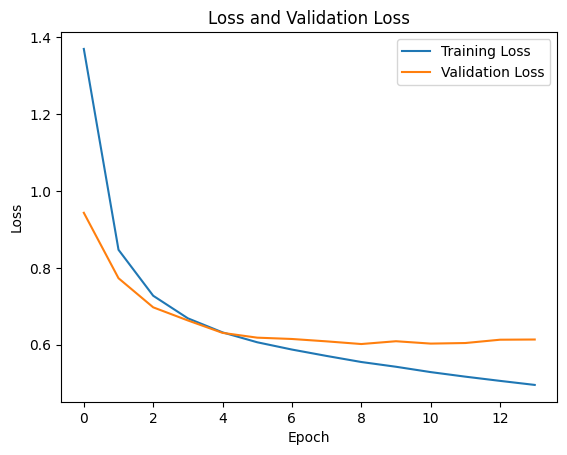

In [ ]:
import matplotlib.pyplot as plt

# Plota a perda (loss) e a perda de validação (val_loss) durante o treinamento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Salva arquivos em discos que podemos carregar sem treinar a rede neural novamente
model.save('/content/drive/My Drive/DatasetColab/ge_BiLSTM_glove6b100d.keras')
np.save("/content/drive/My Drive/DatasetColab/X_test_BiLSTM_glove6b100d.npy", X_test)
np.save("/content/drive/My Drive/DatasetColab/y_test_BiLSTM_glove6b100d.npy", y_test)

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# Carrega arquivos pertinentes ao treinamento da rede neural e X_test e y_test (usados na avaliação de resultados)
model = load_model('/content/drive/My Drive/DatasetColab/ge_BiLSTM_glove6b100d.keras')
X_test = np.load("/content/drive/My Drive/DatasetColab/X_test_BiLSTM_glove6b100d.npy")
y_test = np.load("/content/drive/My Drive/DatasetColab/y_test_BiLSTM_glove6b100d.npy")

# Carrega o tokenizer de um arquivo
with open('/content/drive/My Drive/DatasetColab/tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Acurácia final:', accuracy)

896/896 [==============================] - 23s 23ms/step - loss: 0.6320 - accuracy: 0.7938
Acurácia final: 0.7937594056129456


In [ ]:
# Fazer as previsões do modelo para o conjunto de teste
y_pred = model.predict(X_test)

896/896 [==============================] - 22s 23ms/step


In [ ]:
#Transformar as previsões de volta em rótulos
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

conf_mat

array([[1233,   23,   12,   18,   13,   11,    7,   26,   62,    7,   26,
          11,    6,   10,   19,   16,   44,   13,   26,    7,    5],
       [  15,  415,    3,    4,    3,    3,    4,   13,    3,    2,    6,
           5,    8,   57,    6,   10,    4,    3,   20,    3,    1],
       [  21,   17, 1139,   16,   12,    7,    3,   19,    5,   58,   22,
          16,    9,    8,   18,   23,   30,   10,   15,    7,    5],
       [  16,   13,    4,  881,    0,    9,   14,   10,    3,    3,   16,
          10,    6,    8,   13,    9,   12,    3,   17,    9,   13],
       [  25,   12,    4,   19, 1221,    1,    1,   24,   11,    5,   43,
          18,    8,   11,   20,    9,   22,   13,   11,   10,   27],
       [  17,   15,    3,    5,    1,  404,    4,   17,    5,    3,    1,
           6,    5,    4,    2,    4,   15,    3,   17,    2,    1],
       [  14,   20,    3,   23,   10,    7,  645,   23,    7,    4,   19,
           6,   64,    6,    6,    9,   14,    5,   12,   13,    2],

In [ ]:
import pandas as pd

# Lê o arquivo .csv
df = pd.read_pickle("/content/drive/My Drive/DatasetColab/ge_df.pkl")

# Total de classes (times de futebol)
classes = df['label'].nunique()

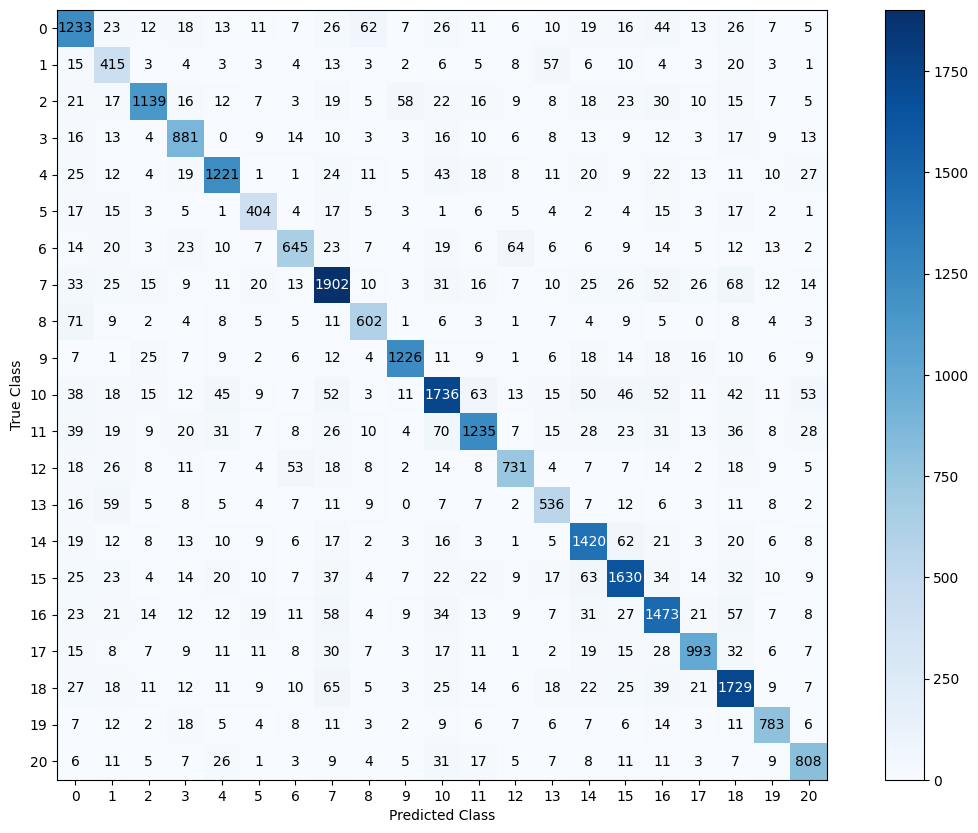

In [ ]:
import matplotlib.pyplot as plt

# Define o tamanho da figura
plt.figure(figsize=(15, 10))

# Define mapa de cores
cmap = plt.cm.Blues

# Plota matriz de confusão
plt.imshow(conf_mat, cmap=cmap)
plt.colorbar()

# Adiciona rótulos a matriz
plt.xticks([int(i) for i in range(classes)], [str(i) for i in range(classes)])
plt.yticks([int(i) for i in range(classes)], [str(i) for i in range(classes)])

for i in range(classes):
    for j in range(classes):
        plt.text(j, i, str(conf_mat[i, j]), ha='center', va='center', color='white' if conf_mat[i, j] > len(y_true_labels)/ classes else 'black')

# Adiciona rótulos dos eixos
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Mostra o plot
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcula precisão, recall e f1-score para cada classe
precisions = []
recalls = []
f1_scores = []
for i in range(classes):
    precision = precision_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    recall = recall_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    f1 = f1_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Printa resultados
for i in range(classes):
    print(f"Class '{i}': Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1-Score={f1_scores[i]:.4f}")

# Calcula e printa a média dos f1-scores
f1_average = np.mean(f1_scores)
print(f"Average F1-Score: {f1_average:.4f}")

Class '0': Precision=0.7318, Recall=0.7730, F1-Score=0.7518
Class '1': Precision=0.5341, Recall=0.7058, F1-Score=0.6081
Class '2': Precision=0.8775, Recall=0.7801, F1-Score=0.8260
Class '3': Precision=0.7852, Recall=0.8241, F1-Score=0.8042
Class '4': Precision=0.8300, Recall=0.8059, F1-Score=0.8178
Class '5': Precision=0.7266, Recall=0.7566, F1-Score=0.7413
Class '6': Precision=0.7771, Recall=0.7072, F1-Score=0.7405
Class '7': Precision=0.7955, Recall=0.8170, F1-Score=0.8061
Class '8': Precision=0.7808, Recall=0.7839, F1-Score=0.7823
Class '9': Precision=0.9008, Recall=0.8652, F1-Score=0.8826
Class '10': Precision=0.8030, Recall=0.7541, F1-Score=0.7778
Class '11': Precision=0.8239, Recall=0.7409, F1-Score=0.7802
Class '12': Precision=0.8068, Recall=0.7505, F1-Score=0.7777
Class '13': Precision=0.7062, Recall=0.7393, F1-Score=0.7224
Class '14': Precision=0.7920, Recall=0.8534, F1-Score=0.8215
Class '15': Precision=0.8179, Recall=0.8097, F1-Score=0.8138
Class '16': Precision=0.7597, Reca

### Inferência

In [ ]:
# Criei um dataframe simples com uma notícia só para aplicarmos a função preprocess_data
import pandas as pd

value = """Santos diz que grupo do Flamengo na Libertadores é difícil e mira tetracampeonato

Flamengo desfruta de dias livres para treinar com foco na final do Campeonato Carioca, mas também já mira a estreia na Libertadores. A estreia na competição continental acontece na próxima quarta-feira, entre as finais do Estadual.

O primeiro jogo será em Quito, no Equador, contra o Aucas, e o goleiro Santos comentou o desejo do Rubro-Negro em conquistar o tetracampeonato na Libertadores.

- A expectativa é sempre muito boa para que essa competição comece. É a principal competição do nosso continente. O grupo é muito difícil, a gente sabe a dificuldade que é a Libertadores. Cada time teve a sua dificuldade para se classificar. A gente está vivendo uma expectativa boa para a estreia, queremos fazer uma boa competição em busca do objetivo que é ser campeão mais uma vez.

Mas, antes de focar na estreia da Libertadores, o Flamengo disputa a primeira partida da final com o Fluminense, no sábado. Para o goleiro, o tempo para treinar em meio ao calendário apertado do futebol brasileiro é algo a ser valorizado.

- Semana muito boa com essa pausa para treinarmos. Estamos muito focados nessa decisão. Os treinos estão com muita intensidade e a gente tem aproveitado o máximo possível para chegarmos preparados.

O Flamengo é o atual campeão da Libertadores e luta pelo tetracampeonato. No Carioca, o Rubro-Negro tenta a revanche em cima do Fluminense, que terminou campeão na temporada de 2022. O segundo e decisivo jogo do Estadual acontece no domingo, dia 9.
"""

# Crie um DataFrame com uma linha e a coluna 'data'
df_predict = pd.DataFrame(data={'data': [value]})

# Faz pré-processamento
preprocess_data(df_predict, 'data')

# Conversão dos dados para serem usados no modelo (rede neural)
preprocessed_articles = df_predict['data'].tolist()

# Tokenização
sequences = tokenizer.texts_to_sequences(preprocessed_articles)

# Padding das sequências para garantir que todas tenham o mesmo comprimento
data = pad_sequences(sequences)

# Fazer a previsão usando o modelo
predictions = model.predict(data)

Removendo pontuação...


100%|██████████| 1/1 [00:00<00:00, 1493.17it/s]


Removendo números...


100%|██████████| 1/1 [00:00<00:00, 1861.65it/s]


Removendo acentos e símbolos diversos...


100%|██████████| 1/1 [00:00<00:00, 1136.98it/s]


Convertendo para minúsculas...


100%|██████████| 1/1 [00:00<00:00, 3006.67it/s]


Computando Lematização...
Processando segmento 1 de 10


100%|██████████| 1/1 [00:00<00:00, 47.07it/s]


Processando segmento 2 de 10


0it [00:00, ?it/s]


Processando segmento 3 de 10


0it [00:00, ?it/s]


Processando segmento 4 de 10


0it [00:00, ?it/s]


Processando segmento 5 de 10


0it [00:00, ?it/s]


Processando segmento 6 de 10


0it [00:00, ?it/s]


Processando segmento 7 de 10


0it [00:00, ?it/s]


Processando segmento 8 de 10


0it [00:00, ?it/s]


Processando segmento 9 de 10


0it [00:00, ?it/s]


Processando segmento 10 de 10


0it [00:00, ?it/s]


Remover tokens com espaços vazios...


100%|██████████| 1/1 [00:00<00:00, 2012.62it/s]


1/1 [==============================] - 2s 2s/step


In [ ]:
predictions

array([[4.9087359e-04, 2.0878924e-04, 5.0157442e-04, 1.3185853e-04,
        2.2089542e-03, 6.4655156e-05, 1.7983837e-05, 5.6940888e-04,
        2.5481852e-06, 2.5654686e-04, 8.1520826e-01, 1.1511928e-02,
        3.8676197e-05, 2.8938348e-06, 6.1320381e-05, 2.5625931e-04,
        1.2446906e-03, 1.6453256e-01, 2.3956098e-04, 1.9233347e-03,
        5.2733225e-04]], dtype=float32)

In [ ]:
# Identificar a classe com a maior probabilidade
predicted_class = np.argmax(predictions)

# Exibir a classe prevista
print(f"Classe prevista: {predicted_class}")

Classe prevista: 10


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Lê o arquivo .csv
df = pd.read_csv('/content/drive/My Drive/DatasetColab/ge_news.csv')

# Cria um objeto LabelEncoder
le = LabelEncoder()

# Transforma os rótulos de times de futebol para variáveis categóricas
df['label'] = le.fit_transform(df['club'])

original_class = le.inverse_transform([predicted_class]) # Transforma a classe predita de variável categórica para o nome do clube, de volta
print(f"Classe original: {original_class[0]}")

Classe original: flamengo


### Inferência 2

In [ ]:
# Criei um dataframe simples e com uma notícia só apenas por conta da função preprocess_data

import pandas as pd

value = """Nova camisa do Corinthians: vazam imagens de supostos uniformes para 2023; veja fotos

Imagens de supostas novas camisas do Corinthians para 2023 vazaram nas redes sociais nessa quarta-feira. Foram divulgadas fotos do que seriam os modelos 1 e 2 do uniforme do Timão.

Uma loja de um shopping na Zona Sul de São Paulo já está comercializando as novas camisas branca e listrada. A reportagem do ge entrou em contato com o estabelecimento e teve a confirmação de um funcionário de que as peças já estão à venda por R$ 300 (modelo de torcedor). Confira as imagens abaixo:

As supostas novas camisas do Corinthians para 2023 possui detalhes na cor vermelha ao redor da logomarca da Nike, fornecedora do material esportivo do clube.

Os uniformes alvinegros para este ano homenagearão a Democracia Corinthiana, movimento organizado na década de 1980. CLIQUE AQUI e saiba mais sobre o tema.

Usualmente, o Corinthians lança seus novos uniformes principais entre o fim de abril e o início de maio. Já a terceira camisa costuma ser estreada em setembro, mês de aniversário do clube.

O Timão volta a campo na próxima quinta-feira, na estreia da Libertadores, contra o Liverpool-URU, às 19h, no estádio Centenário de Montevidéu.
"""

# Crie um DataFrame com uma linha e a coluna 'data'
df_predict = pd.DataFrame(data={'data': [value]})

# Faz pré-processamento
preprocess_data(df_predict, 'data')

# Conversão dos dados para serem usados no modelo (rede neural)
preprocessed_articles = df_predict['data'].tolist()

# Tokenização
sequences = tokenizer.texts_to_sequences(preprocessed_articles)

# Padding das sequências para garantir que todas tenham o mesmo comprimento
data = pad_sequences(sequences)

# Fazer a previsão usando o modelo
predictions = model.predict(data)

Removendo pontuação...


100%|██████████| 1/1 [00:00<00:00, 1025.00it/s]


Removendo números...


100%|██████████| 1/1 [00:00<00:00, 1663.75it/s]


Removendo acentos e símbolos diversos...


100%|██████████| 1/1 [00:00<00:00, 958.04it/s]


Convertendo para minúsculas...


100%|██████████| 1/1 [00:00<00:00, 1912.59it/s]


Computando Lematização...
Processando segmento 1 de 10


100%|██████████| 1/1 [00:00<00:00, 41.77it/s]


Processando segmento 2 de 10


0it [00:00, ?it/s]


Processando segmento 3 de 10


0it [00:00, ?it/s]


Processando segmento 4 de 10


0it [00:00, ?it/s]


Processando segmento 5 de 10


0it [00:00, ?it/s]


Processando segmento 6 de 10


0it [00:00, ?it/s]


Processando segmento 7 de 10


0it [00:00, ?it/s]


Processando segmento 8 de 10


0it [00:00, ?it/s]


Processando segmento 9 de 10


0it [00:00, ?it/s]


Processando segmento 10 de 10


0it [00:00, ?it/s]


Remover tokens com espaços vazios...


100%|██████████| 1/1 [00:00<00:00, 305.26it/s]


1/1 [==============================] - 0s 38ms/step


In [ ]:
predictions

array([[4.8945744e-06, 2.2905922e-07, 6.0897232e-06, 1.3830193e-05,
        3.1221356e-05, 1.2485384e-06, 4.7044409e-06, 9.9974483e-01,
        2.2312489e-07, 1.0135480e-05, 3.8598087e-06, 4.2463504e-05,
        2.0327768e-07, 1.0201612e-06, 4.0590781e-05, 5.1940962e-05,
        2.0751662e-05, 1.0438144e-05, 8.0751315e-06, 1.7004786e-06,
        1.7365032e-06]], dtype=float32)

In [ ]:
# Identificar a classe com a maior probabilidade
predicted_class = np.argmax(predictions)

# Exibir a classe prevista
print(f"Classe prevista: {predicted_class}")

Classe prevista: 7


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Lê o arquivo .csv
df = pd.read_csv('/content/drive/My Drive/DatasetColab/ge_news.csv')

# Cria um objeto LabelEncoder
le = LabelEncoder()

# Transforma os rótulos de times de futebol para variáveis categóricas
df['label'] = le.fit_transform(df['club'])

original_class = le.inverse_transform([predicted_class]) # Transforma a classe predita de variável categórica para o nome do clube, de volta
print(f"Classe original: {original_class[0]}")

Classe original: corinthians


# Referências

* https://nlp.stanford.edu/projects/glove/
* https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010